In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from functools import partial
import sys
from pathlib import Path

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMP import *
from src.causalKLGP import *
from src.kernels import *
from src.GP_utils import *
from src.kernel_utils import *
from src.dgps import *
from src.CBO import *

In [2]:
# Getting inerventional data
n_int = 100
int_samples = 10**5
dostatin = torch.linspace(0,1,n_int)
age, bmi, aspirin, statin, cancer, psa = STATIN_PSA(int_samples, seed = 0, gamma = False, 
               interventional_data = True, dostatin=dostatin)
psa,fvol, vol = PSA_VOL(psa = psa)

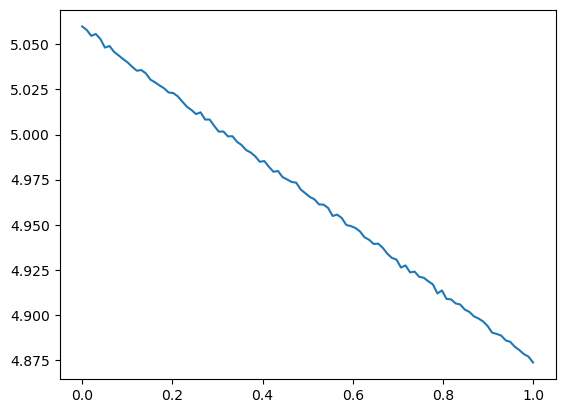

In [3]:
plt.plot(dostatin,fvol.reshape(n_int,int_samples).mean(1));

In [4]:
# Settings
method = "causalklGP" 
retrain_hypers = False
sample_split = True,
marginal_loss = False
cal_nulist = 2**torch.linspace(-4,4,5)
niter = 1000
learn_rate = 0.1

samples = 100

In [5]:
# Getting training data
age_, bmi_, aspirin_, statin_, cancer_, psa_ = STATIN_PSA(samples, seed = 0, gamma = False, 
               interventional_data = False, dostatin=[])
psa_, fvol_, vol_ = PSA_VOL(psa = psa_)

# Training causalKLGP
A = torch.column_stack((age_, bmi_, aspirin_, statin_))
V = psa_.reshape(len(psa_),1)
Y = vol_

In [6]:
if method == "bayesimp":
    model = BayesIMP(Kernel_A = GaussianKernel, 
               Kernel_V = GaussianKernel, 
               Kernel_Z = [],
               dim_A = A.size()[1], 
               dim_V = V.size()[1], 
               samples = 10**5,
               exact = True)

    model.train(Y,A,[V,V],niter,learn_rate, optimise_measure = True, mc_samples = 100)
else:
    model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5,
                   scale_V_init = Y.var()**0.5/2,
                   noise_Y_init = torch.log(Y.var()/4)
                  )
    
    model.train(Y, A, V, niter, learn_rate, force_PD = True)

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/causalKLGP.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.noise_Y = torch.tensor(noise_Y_init, requires_grad = True).float()


iter 0 P(Y|V) loss:  tensor(252.0963)
iter 100 P(Y|V) loss:  tensor(165.4094)
iter 200 P(Y|V) loss:  tensor(165.1214)
iter 300 P(Y|V) loss:  tensor(165.0002)
iter 400 P(Y|V) loss:  tensor(164.9309)
iter 500 P(Y|V) loss:  tensor(164.8854)
iter 600 P(Y|V) loss:  tensor(164.8530)
iter 700 P(Y|V) loss:  tensor(164.8285)
iter 800 P(Y|V) loss:  tensor(164.8093)
iter 900 P(Y|V) loss:  tensor(164.7938)
iter 0 P(V|A) loss:  tensor(-1053.5826)
iter 100 P(V|A) loss:  tensor(-6714.4658)
iter 200 P(V|A) loss:  tensor(-6835.5234)
iter 300 P(V|A) loss:  tensor(-6887.8135)
iter 400 P(V|A) loss:  tensor(-6922.7593)
iter 500 P(V|A) loss:  tensor(-6950.2227)
iter 600 P(V|A) loss:  tensor(-6971.4380)
iter 700 P(V|A) loss:  tensor(-6988.8643)
iter 800 P(V|A) loss:  tensor(-7003.0239)
iter 900 P(V|A) loss:  tensor(-7015.3179)


In [7]:
# Example functions to estimate \hat{E}[Y|do(X=x)] and \hat{Var}[\hat{E}[Y|do(X=x)]]
def estimate_mean(X):
    return torch.zeros(len(X),1) # Replace with actual estimation logic

def estimate_var(X):
    return torch.zeros(len(X),1)  # Replace with actual estimation logic

In [8]:
# Example functions to estimate \hat{E}[Y|do(X=x)] and \hat{Var}[\hat{E}[Y|do(X=x)]]
def estimate_mean(X):
    doA = X.reshape(len(X),1)
    return model.post_mean(Y,A,V,doA,reg = 1e-3, average_doA = True, intervention_indices = [3])  # Replace with actual estimation logic

if method != "bayesimp":
    def estimate_var(X, diag = True):
        doA = X.reshape(len(X),1)
        return model.post_var(Y,A,V,doA,reg = 1e-3,nu = 1, average_doA = True, intervention_indices = [3], diag = diag)  # Replace with actual estimation logic
    
    def estimate_cov(X, Z, diag = False):
        doA = X.reshape(len(X),1)
        doA2 = Z.reshape(len(Z),1)
        return model.post_var(Y,A,[V,V],doA,doA2,reg = 1e-3,nu = 1, average_doA = True, intervention_indices = [3], diag = diag)  # Replace with actual estimation logic
else:
    def estimate_var(X, diag = True):
        doA = X.reshape(len(X),1)
        return model.post_var(Y,A,[V,V],doA,reg = 1e-3, average_doA = True, intervention_indices = [3], diag = diag)  # Replace with actual estimation logic
    
    def estimate_cov(X, Z, diag = False):
        doA = X.reshape(len(X),1)
        doA2 = Z.reshape(len(Z),1)
        return model.post_var(Y,A,[V,V],doA,doA2,reg = 1e-3, average_doA = True, intervention_indices = [3], diag = diag)  # Replace with actual estimation logic

In [14]:
if method == "bayesimp":
    gp = GaussianProcess(X_train=V, y_train=Y.reshape(len(Y),1), kernel=model.kernel_V, mean = lambda x : 0, noise_init=model.noise_Y, nugget=1e-3)
else:
    gp = GaussianProcess(X_train=V, y_train=Y.reshape(len(Y),1), kernel=model.kernel_V.base_kernel, mean = lambda x : 0, noise_init=model.noise_Y, nugget=1e-3)
mu,cov = gp(V)

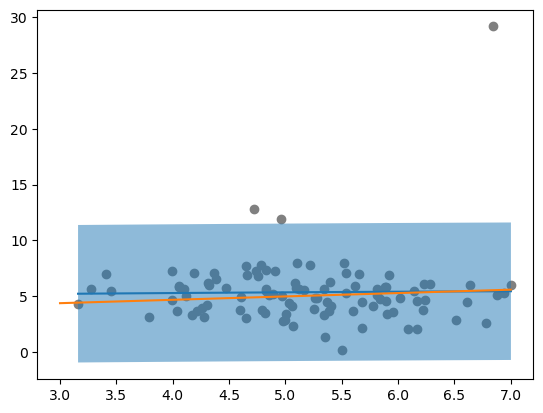

In [16]:
plt.scatter(V,Y, color = "grey")
inds = V.sort(0)[1][:,0]
plt.plot(V[inds],mu.detach()[inds])
plt.fill_between(V[inds][:,0],(mu - 2*cov.diag()**0.5)[inds].detach()[:,0],(mu + 2*cov.diag()**0.5)[inds].detach()[:,0], alpha = 0.5)
x = torch.linspace(3,7,100)
plt.plot(x,  3.476 + 0.302*x)

In [17]:
m,v = estimate_mean(dostatin),estimate_cov(dostatin,dostatin,False).diag()[:,None]

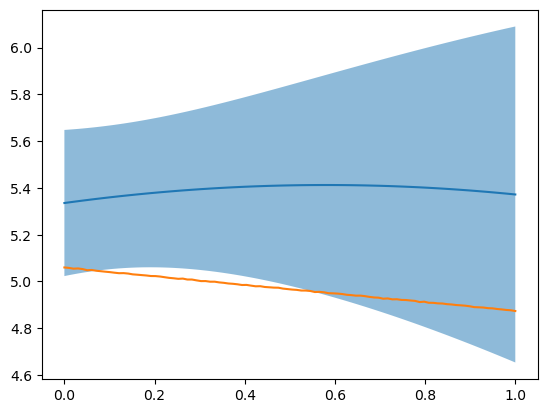

In [18]:
plt.plot(dostatin[:,None],m.detach())
plt.plot(dostatin,fvol.reshape(n_int,int_samples).mean(1));
plt.fill_between(dostatin, (m - v**0.5)[:,0], (m + v**0.5)[:,0], alpha = 0.5)

In [19]:
class CBOPriorKernel:
    def __init__(self,kernel_func):
        self.kernel_func = kernel_func

    def get_gram(self,X,Z):
        return self.kernel_func(X,Z)

In [20]:
trials = 1
n_iter = 10
xi = 0.0
update_interval = 100
hyperparam_steps = 10
use_cbo_kernel = True

Y_train = torch.zeros((trials,n_iter+1))
for i in range(trials):

    if use_cbo_kernel:
        # Instantiate the RBF kernel
        medheur = median_heuristic(statin[:,None].reshape(n_int,int_samples).mean(1)[:,None])
        rbf_kernel = GaussianKernel(lengthscale=torch.tensor([medheur]).requires_grad_(True), 
                                scale=torch.tensor([vol.var()**0.5]).requires_grad_(True))
        # Define the CBO kernel    
        causal_kernel = CausalKernel(
            estimate_var_func=estimate_var,
            base_kernel=rbf_kernel,
            add_base_kernel=True  # Set to False if you don't want to include the base kernel
        )
    else:
        causal_kernel = CBOPriorKernel(estimate_cov)
    
    # Define a grid of intervention points and precompute E[Y|do(x)]
    X_test = dostatin[:,None]
    Y_test = fvol.reshape(n_int,int_samples).mean(1)[:,None]

    # Random search for first intervention point
    start = torch.randint(0,99,(1,))[0]
    X_start,y_start = X_test[start].reshape(1,1),Y_test[start].reshape(1,1)
    
    # Run CBO
    X_train, y_train = causal_bayesian_optimization(X_train=X_start, 
                                                    y_train=y_start, 
                                                    kernel=causal_kernel, 
                                                    mean = estimate_mean,
                                                    X_test=X_test, 
                                                    Y_test=Y_test, 
                                                    n_iter=n_iter, 
                                                    update_interval=update_interval,
                                                    xi = xi, 
                                                    print_ = True, 
                                                    minimise = True,
                                                    hyperparam_steps = hyperparam_steps,
                                                    noise_init = -10.0)
    Y_train[i] = y_train[:,0]

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/CBO.py:9: SyntaxWarning: invalid escape sequence '\h'
  """
/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/CBO.py:24: SyntaxWarning: invalid escape sequence '\h'
  """


NameError: name 'Y_train' is not defined

In [ ]:
plt.fill_between(torch.linspace(0,len(Y_train.T)-1,len(Y_train.T)),
                 Y_train.mean(0) - Y_train.var(0)**0.5,
                 Y_train.mean(0) + Y_train.var(0)**0.5, alpha = 0.5)
plt.plot(Y_train.mean(0))

In [36]:
n_iter=1
update_hyperparameters=True
update_interval=100
hyperparam_steps=1
lr=0.01
xi = 0
minimise = True
use_cbo_kernel = True

if use_cbo_kernel:
    # Instantiate the RBF kernel
    medheur = median_heuristic(statin[:,None].reshape(n_int,int_samples).mean(1)[:,None])
    rbf_kernel = GaussianKernel(lengthscale=torch.tensor([medheur]).requires_grad_(True), 
                            scale=torch.tensor([vol.var()**0.5]).requires_grad_(True))
    # Define the CBO kernel    
    causal_kernel = CausalKernel(
        estimate_var_func=estimate_var,
        base_kernel=rbf_kernel,
        add_base_kernel=True  # Set to False if you don't want to include the base kernel
    )
else:
    causal_kernel = CBOPriorKernel(estimate_cov)
    
# Define a grid of test points
X_test = dostatin[:,None]
Y_test = fvol.reshape(n_int,int_samples).mean(1)[:,None]

int_ = torch.randint(0,99,(1,))[0]

X_train,y_train = X_test[int_].reshape(1,1),Y_test[int_].reshape(1,1)#torch.empty((0,X_test.shape[1])), torch.empty((0,1))

gp = GaussianProcess(X_train=X_train, y_train=y_train, kernel=causal_kernel, mean = estimate_mean, nugget = 1e-1)

# Initialize the maximum observed value
y_best = float(0)

Iteration 1: X = 1.0, Y = 4.873682975769043


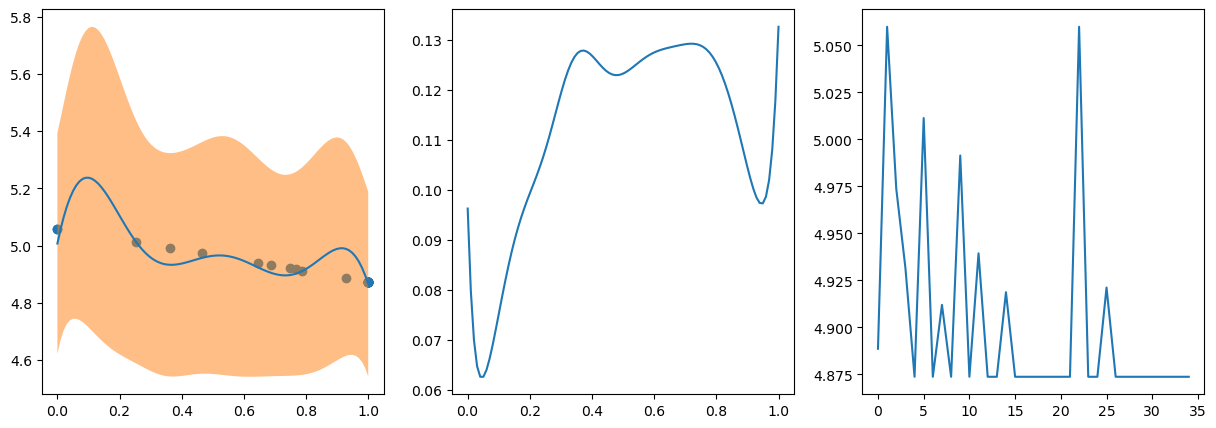

In [70]:
for i in range(n_iter):
        # Get the GP predictions for the test grid
        mu_s, cov_s = gp(X_test)
        sigma_s = torch.sqrt(torch.diag(cov_s))

        # Calculate the Expected Improvement
        ei = expected_improvement(mu_s[:,0], sigma_s, y_best, xi = xi, minimise = minimise)

        # Find the next best point
        next_index = torch.argmax(ei)
        next_x = X_test[next_index]
        next_y = Y_test[next_index]

        # Update the training data with the new point
        X_train = torch.cat((X_train, next_x.unsqueeze(0)), dim=0)
        y_train = torch.cat((y_train, next_y.unsqueeze(0)), dim=0)

        # Update GP model with new data
        gp.X_train = X_train
        gp.y_train = y_train

        # Perform hyperparameter optimization if required
        if update_hyperparameters and (i + 1) % update_interval == 0:
            gp.optimize_hyperparameters(num_steps=hyperparam_steps, lr=lr)

        # Update the best observed value
        y_best = torch.min(y_train)
        
        print(f"Iteration {i+1}: X = {next_x.item()}, Y = {next_y.item()}")

fig,axs = plt.subplots(1,3,figsize = (15,5))
axs[0].scatter(X_train,y_train)
axs[0].plot(X_test,mu_s.detach())
axs[0].fill_between(X_test[:,0],(mu_s[:,0] - sigma_s).detach(),(mu_s[:,0] + sigma_s).detach(), alpha = 0.5)
axs[1].plot(X_test,ei)
axs[2].plot(y_train)

In [ ]:
doA_ = model.expand_doA_with_replacement(doA, A, [0,1,2])
doA_.size()

In [ ]:
K = GaussianKernel().get_gram(doA_,A)

In [ ]:
(K.reshape(samples,n_int,samples).mean(0) @ GaussianKernel().get_gram(A,A))

In [ ]:
(K @ GaussianKernel().get_gram(A,A)).reshape(samples,n_int,samples).mean(0)